In [42]:
from langchain import VectorDBQA, HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.schema import Document
from langchain.retrievers import BM25Retriever
from sklearn.metrics.pairwise import cosine_similarity


import transformers 
from transformers import pipeline
import pandas as pd
from tqdm.auto import tqdm
import warnings
import json
import re
warnings.filterwarnings('ignore')

## Ingestion



In [9]:
daily_dialog = pd.read_csv('./../data/daily_dialog.csv')


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

#vectorstore = FAISS.from_documents(texts, embeddings)


len(embeddings.embed_documents(['How to get fit?'])[0])


384

In [12]:
#'text':row.text
docs = [Document(page_content=row.text,metadata={'id':idx,'emoji':row.emoji,'action':row.action }) for idx ,row in daily_dialog.iterrows()]


In [13]:
len(docs),docs[0]

(10549,
 Document(metadata={'id': 0, 'emoji': ' happiness ', 'action': ' directive , commissive , question , inform '}, page_content="Say , Jim , how about going for a few beers after dinner ?   You know that is tempting but is really not good for our fitness .   What do you mean ? It will help us to relax .   Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ?   I guess you are right.But what shall we do ? I don't feel like sitting at home .   I suggest a walk over to the gym where we can play singsong and meet some of our friends .   That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them .   Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too .   Good.Let ' s go now .   All right . "))

In [14]:


vectorstore = FAISS.from_documents(docs, embeddings)

# Persist the FAISS index to disk for later use (similar to Chroma persist_directory)
vectorstore.save_local("./../data/dialog_index")


## RAG flow

In [2]:

# setup pipeline model
pipe = pipeline("text-generation",
        model="Qwen/Qwen2.5-0.5B", 
        device_map="auto",
        max_new_tokens=256,
        temperature=0.3,
       )

query = 'How can I handle sadness and lonely?'


In [15]:
def dense_search(query,k=2):
    
    return vectorstore.similarity_search_with_score(query, k=k,)
   
ans = dense_search(query,5)

In [77]:
ans[0][0].metadata['id']

3633

In [5]:
##     "content": "You are a professional life coach, offering personalized advice in different areas such as work, communication, hobbies, and lifestyle. It will provide suggestions to improve mood, recommend fun activities, and inspire productivity  ",

prompt_template = """
To answer QUESTION Use only the facts from the CONTEXT when answering the QUESTION.
Read CONTEXT carefully to learn and give an accurate answer without hallucinations.
In the CONTEXT you will have emojis and action help you to understand the text and use it.

QUESTION: 
'''{question}'''

CONTEXT:
'''{context}'''




""".strip()

entry_template = """
emoji: {emoji}
action: {action}
dailog: {text}
""".strip()

def build_prompt(query, search_results):
    context = ""
    
    for doc in search_results:
        context = context + entry_template.format(emoji = doc[0].metadata['emoji'],
                                                  action = doc[0].metadata['action'],
                                                  text = doc[0].page_content) +'\n\n'

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [4]:
def llm(prompt):
    messages = [
    {"role"   : "system",
     "content": "You are a professional life coach, offering personalized advice in different areas such as work, communication, hobbies, and lifestyle. It will provide suggestions to improve mood, recommend fun activities, and inspire productivity. Answer the QUESTION based on the CONTEXT come from the user role. ",
      "role": "user", 
     "content": prompt,
   
    }
                ]
    return pipe(messages)[0]['generated_text'][1]['content']
    


In [16]:
def rag(query):
    search_results = dense_search(query,k=1)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [81]:
query = 'How can I handle sadness and lonely?'
answer = rag(query)
print(answer)

To handle sadness and loneliness, you can try the following:

1. Stay in touch with your loved ones: Reach out to your family and friends to express your feelings and share your thoughts. You can also consider visiting them in person or sending them messages to express your love and support.

2. Engage in activities that bring you joy: Participate in activities that bring you pleasure and relaxation, such as reading, watching movies, or playing games. This can help you feel more connected to the world around you.

3. Practice self-care: Take care of your physical and mental health by getting enough sleep, eating a healthy diet, and engaging in regular exercise. This can help you feel more relaxed and centered.

4. Connect with others: Join a support group or community where you can connect with others who share similar experiences. This can provide a sense of belonging and help you feel less alone.

5. Seek professional help: If you are struggling with feelings of sadness and lonelines

## Retrieval evaluation

In [17]:
df_question = pd.read_csv('../data/daily_dialog_ground_truth.csv')

In [18]:
ground_truth = df_question.to_dict(orient='records')

ground_truth[0]


{'dialogue_id': 8777,
 'query': " we don't give discounts .   In that case ",
 'ground_truth_response': " I don't think I'll buy one here . "}

In [19]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [20]:
def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['dialogue_id']
        results = search_function(q)
        relevance = [d[0].metadata['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [20]:
evaluate(ground_truth, lambda q: dense_search(q['query'],k = 10))

  0%|          | 0/1000 [00:00<?, ?it/s]

{'hit_rate': 0.595, 'mrr': 0.4790103174603172}

{'hit_rate': 0.595, 'mrr': 0.4790103174603172}


In [21]:
from langchain.retrievers import BM25Retriever

# Initialize BM25 retriever
bm25_retriever = BM25Retriever.from_documents(docs)

def hybrid_search( query, k=10):
    # Perform dense retrieval using FAISS (which returns tuples of (Document, score))
    dense_results = vectorstore.similarity_search_with_score(query, k=k)

    # Perform sparse retrieval using BM25 (which may return only Document objects)
    sparse_docs = bm25_retriever.get_relevant_documents(query)
    
    # Assign a default score to the sparse results, e.g., BM25 doesn't return a score
    sparse_results = [(doc, 1.0) for doc in sparse_docs]  # Assuming default score is 1.0
    
    # Combine the results
    combined_results = dense_results + sparse_results

    # Sort by score (assuming higher score is better)
    combined_results.sort(key=lambda x: x[1], reverse=True)

    # Return the top k results
    return combined_results[:k]



In [22]:
evaluate(ground_truth, lambda q: hybrid_search(q['query'],k = 10))

  0%|          | 0/1000 [00:00<?, ?it/s]

{'hit_rate': 0.677, 'mrr': 0.2571920634920627}

In [22]:
def sparse_search( query, k=10):

    # Perform sparse retrieval using BM25 (which may return only Document objects)
    sparse_docs = bm25_retriever.get_relevant_documents(query)
    
    # Assign a default score to the sparse results, e.g., BM25 doesn't return a score
    sparse_results = [(doc,1) for doc in sparse_docs]  # Assuming default score is 1.0
    
    
    return sparse_results


In [24]:
evaluate(ground_truth, lambda q: sparse_search(q['query'],k = 10))

  0%|          | 0/1000 [00:00<?, ?it/s]

{'hit_rate': 0.786, 'mrr': 0.7405}

In [25]:
#!python3.10 -m pip install rank_bm25

{'hit_rate': 0.677, 'mrr': 0.2571920634920627}

note:- big improvement in hit_rate using hybrid_search


{'hit_rate': 0.786, 'mrr': 0.7405}
wow that is best result for now at all when use only sparse retrieval


 so let's replace the search part in rag function

In [23]:
def rag_updated(query):
    search_results = sparse_search(query,k=3)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [27]:
query = 'How can I handle sadness and lonely?'
answer = rag(query)
print(answer)

To handle sadness and loneliness, you can try the following:

1. Take care of yourself: Make sure you take care of your physical and mental health. Get enough sleep, eat healthy food, and exercise regularly. Take time for yourself to relax and enjoy your hobbies.

2. Connect with others: Reach out to friends and family members who can support you. Join a support group or talk to a therapist if you need help.

3. Practice self-care: Take care of your physical and mental health by practicing self-care activities such as meditation, yoga, or exercise.

4. Seek professional help: If you are struggling with sadness and loneliness, consider seeking professional help from a therapist or counselor. They can provide you with tools and techniques to cope with your feelings.

5. Focus on the positive: Try to focus on the positive aspects of your life and the things that make you happy. This can help you feel more positive and hopeful about your future.

Remember, it's important to take care of yo

## RAG evaluation

In [24]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
llm2 = pipeline("text-generation",
                model="Qwen/Qwen2.5-0.5B-Instruct", 
                device_map="auto",
                max_new_tokens=256,
                temperature=0.3,)
llm2(messages)

[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': 'I am Qwen, an artificial intelligence developed by Alibaba Cloud. I was created to assist users in various tasks and provide them with information and insights on specific topics. My primary focus is to help people find the answers they need quickly and efficiently. If you have any questions or need assistance, feel free to ask!'}]}]

In [27]:
prompt2_template = """
You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {query}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [50]:
len(ground_truth)

1000

In [29]:
record = ground_truth[0]

In [30]:
print(record)

{'dialogue_id': 8777, 'query': " we don't give discounts .   In that case ", 'ground_truth_response': " I don't think I'll buy one here . "}


In [31]:
answer_llm = rag(record['query'])

In [32]:
prompt = prompt2_template.format(query=record['query'], answer_llm=answer_llm)
print(prompt)

You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question:  we don't give discounts .   In that case 
Generated Answer: Yes, I understand. Let's break down the conversation step by step:

1. The user mentions that they don't give discounts.
2. The user asks if they can allow any discount for this commodity.
3. The user expresses that they usually get a discount from other suppliers.
4. The user mentions that they usually get a discount of 3% to 5% from their other suppliers.
5. The user asks if they can give any more discounts.
6. The user expresses that they can't make an exception.
7. The user asks if they can give any more discounts.
8. The user expresses that they can't give any more discounts.
9. The user asks if they can give any more discounts.

In [33]:
def eval_llm(prompt):
    messages = [
    {    "role": "user", 
     "content": prompt,
   
    }
                ]
    return llm2(messages)[0]['generated_text'][1]['content']

In [35]:
df_question.head()

dialogue_id                                              query  \
0         8777          we don't give discounts .   In that case    
1         7369  Both of the two young ladies are the candidate...   
2         5491                         maybe not a Michael Zhang    
3        10529   Jim's here ! I've been waiting to hear him si...   
4         1247                                        No dialogue   

                               ground_truth_response  
0                 I don't think I'll buy one here .   
1   the tall one or the short one ?   I should ta...  
2   but better than the average . Person would yo...  
3   you asked for it . Why don't you put on an El...  
4                                        No response

In [64]:
import json
import re

df_sample = df_question.sample(n=100, random_state=1)

sample = df_sample.to_dict(orient='records')

evaluations = []

for record in tqdm(sample):
    question = record['query']
    answer_llm = rag_updated(question) 
    right_answer = record['ground_truth_response']
    id = record['dialogue_id']
    prompt = prompt2_template.format(query=question, answer_llm=answer_llm)

   
    evaluation = eval_llm(prompt)
    match = re.search(r'```json(.*?)```', evaluation, re.DOTALL)

   
    extracted_content = match.group(1).strip()  # Extract the content and remove leading/trailing whitespace
   

    
    evaluation = json.loads(extracted_content)

    evaluations.append((id,record,right_answer, answer_llm, evaluation))



  0%|          | 0/100 [00:00<?, ?it/s]

In [65]:
df_eval = pd.DataFrame(evaluations, columns=['id','record','right_answer' ,'answer', 'evaluation'])

df_eval['id'] = df_eval.record.apply(lambda d: d['dialogue_id'])
df_eval['question'] = df_eval.record.apply(lambda d: d['query'])

df_eval['relevance'] = df_eval.evaluation.apply(lambda d: d['Relevance'])
df_eval['explanation'] = df_eval.evaluation.apply(lambda d: d['Explanation'])

del df_eval['record']
del df_eval['evaluation']

In [69]:
df_eval.relevance.value_counts()

relevance
PARTLY_RELEVANT    95
RELEVANT            4
NON_RELEVANT        1
Name: count, dtype: int64

In [66]:
df_eval.relevance.value_counts(normalize=True)

relevance
PARTLY_RELEVANT    0.95
RELEVANT           0.04
NON_RELEVANT       0.01
Name: proportion, dtype: float64

In [67]:
df_eval.head()

id                                       right_answer  \
0   6524           I see . Thank you !   You are welcome !    
1  10422                           Craig ! I'm impressed .    
2   7911   you call them .   Then you go out to the gara...   
3   9125   and drink beer and so on . But after a few we...   
4   7328                 but that was definitely my line .    

                                              answer  \
0  Yes, I can help you with that. Let's break dow...   
1  Assistant: To answer the question, I will anal...   
2  Yes, I understand the context. The user is ask...   
3  Ben is drifting in the pool, enjoying the comf...   
4  Yes, I understand the context. The user is dis...   

                                            question        relevance  \
0   and you will see a big bus station there .   Ok   PARTLY_RELEVANT   
1   too . Will get a better response . I'll post ...         RELEVANT   
2   that's right . Renting is good !   Should we ...  PARTLY_RELEVANT   
3                                    and lie around   PARTLY_RELEVANT   
4        Mark . I know we worked on the ad together   PARTLY_RELEVANT   

                                         explanation  
0  The generated answer provides some information...  
1  The generated answer contains a clear and rele...  
2  The generated answer contains multiple questio...  
3  The generated answer provides a detailed descr...  
4  The generated answer provides some relevant in...

All answers PARTLY_RELEVANT using Qwen2.5-0.5B-Instruct llm i understand that because the ground_truth data is not good enough it's created form last 2 sentences from dialog as a question and it's answer so let's try another way using cosine similarity

In [77]:
for index, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
    llm_answer = embeddings.embed_documents([row['answer']])
    right_answer = embeddings.embed_documents([row['right_answer']])
    df_eval.loc[index,'cosine_score'] =  cosine_similarity(llm_answer, right_answer)[0][0] 
    #print( cosine_similarity(llm_answer, right_answer)[0][0] )

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
df_eval.cosine_score.describe()

count    100.000000
mean       0.271979
std        0.206015
min       -0.059649
25%        0.118552
50%        0.219197
75%        0.372294
max        0.885515
Name: cosine_score, dtype: float64

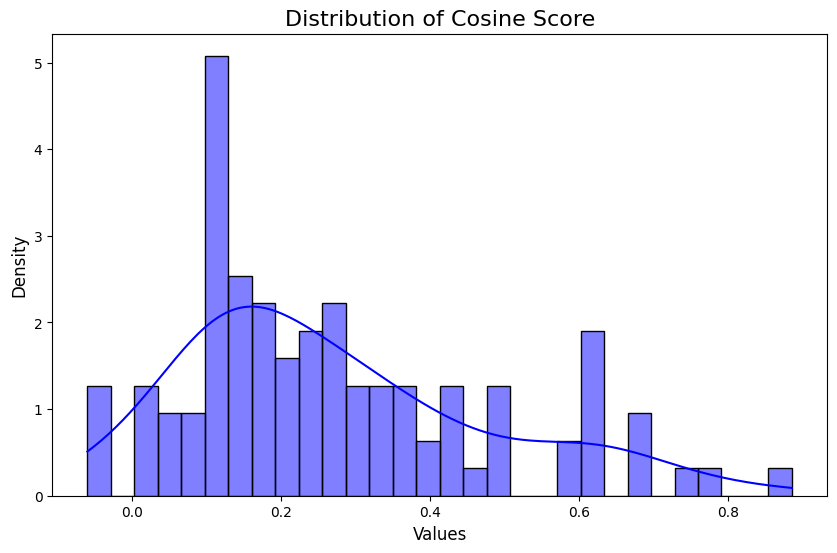

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_eval is your DataFrame and you want to plot a column's distribution
# Replace 'column_name' with the actual column you want to visualize
series = df_eval['cosine_score']

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the distribution using seaborn (both histogram and KDE)
sns.histplot(series, bins=30, kde=True, color='blue', stat='density')

# Add titles and labels
plt.title('Distribution of Cosine Score', fontsize=16)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Show the plot
plt.show()


Not so good cosine score as mention before maybe need a more sophistication way to build a ground truth data

In [73]:
df_eval.to_csv('../data/rag-eval.csv', index=False)